<img src="imgs/dataset-cover.png">

# Contents
* [Intro](#intro)
* [The Project](#project)
* [Data Prep](#prep)
* [Building The Network](#network)
* [What Is A Neural Network](#whatisanetwork)
* [Building Blocks](#buildingblocks)
* [Initialisation](#init)
* [Forward Pass](#forward)
* [Backward Pass](#backward)
* [Update Weights](#update)
* [Testing & Evaluation](#testing)
* [Conclusion](#conclusion)
* [References](#references)
* [Other Resources](#resources)



# Intro <a  id="intro"></a>

This notebook is written to illustraste how to build a simple 2 layer neural network from scratch! I have wanted to do this for a long time now as I notice that when I was learning about neural networks I had a tendency to skip straight to the cool stuff. Using great libraries like tensorflow and keras lets you build really cool projects with neural networks quickly and easily, which is great. However I noticed that there were big gaps in my understanding neural networks and I realised I didnt really understand their workings at a low level. This notebook was a great exercise in really understanding the low level concepts of neural networks and I hope that others will find it usefull as well. Any feedback or constructive criticism would be appreciated.

## The Project <a  id="project"></a>

In this project we will be trying to diagnose whether a tumor found in breast cancer is malignent or benign. This will be using the Breast Cancer Wisconsin data set found <a href="https://www.kaggle.com/uciml/breast-cancer-wisconsin-data">here</a>. 

This is a relatively small dataset with 569 entries. These datapoints contain 30 features that we will learn from and a binary classifcation of malignent "M" or benign "B". Like all ML models, this project is split up into 2 parts, data preparation and the building of the model. If you want to just skip to the code for the network head to [Building The Network](#network)



## Data Prep <a  id="prep"></a>

All ML projects are different. Even if we use the same model, the data being used is rarely the same. Its also worth noting that good data is more important than a good model. Much like in nutrition, you cant out exercise a bad diet. If you're putting bad food into your body, your gonna see bad results. In ML it doesn't really matter how amazing and complicated your model is if you are feeding it bad data. Because of this, it is important to pay attention to our data preparation phase. This notebook just carrys out very basic data preparation but the Kaggle contributer Kaan Can has a very comprehensive tutorial that covers all the necessary skils for data science and has a whole section on cleaning data. The tutorial can be found <a href="https://www.kaggle.com/kanncaa1/data-sciencetutorial-for-beginners">here</a>

Now on to the actual code! The first thing we need to do is import any libraries such as pandas and then load in our data set.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('/floyd/input/breast-cancer-wisconsin/breastcancer.csv')
print(data.shape)
data.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


As you can see from the snapshot of our dataset we have 569 columns with 33 rows. After a quick glance through our data we can see that we dont need all of it. The last column is simply empty data so the first thing we will do is remove it.

In [2]:
del data['Unnamed: 32']

The next step is to seperate our feature data and our targets. The features is the data we want to learn from in order and the targets is the diagnosis, wether or not the tumor is malignent. 

In [3]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

If we look at our target labels, they are represented as either 'M' or 'B'. Now this makes the data easily readible for humans, but its actaully harder for a machine to interpret this. In order to make our labels more machine friendly we are going to change the labels to be either 1 or 0. Because im lazy, im going to use the sklearn libaray to quickly do this

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

The next thing we will look at is splitting up our data. Whenever we are training our models we need to divide our data into 2 sets, a training set and a testing set. To do this we randomly sample from our entire dataset and split the data with roughly a 70:30 ratio, but this can vary depending on the project. 

You might be thinking "well, we dont have much data to begin with, why dont we just train our model with all of our data and get the most out of what we have?" and thats a good question. The reason is that we dont want our model to overfit to the training data. 

Overfitting means that our model has gotten REALLY good at understanding and predicting the training data and can have a really high training accuracy. However, the model has ONLY learned about the training data and hasnt learned how to generalise. So when we introduce some new data, the model will perform poorly. Its like when you are studying for a test, but you have only studied the past exam papers. You have gotten really good at answering those specific questions, but when you are asked questions that didnt come up in the past exam papers, you cant answer them because you haven't really learned the topic. 

In order to identify if this is happening to our model we always train the model on a sub section of the data and then test the model on another portion of the dataset to ensure that it is learning correctly.

Also, it is important that the data is randomly sampled, otherwise you might get data sets that contain highly correlated data and can effect your results.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

The final task we need to carry out is called feature scaling. At the minute our data is looking good and it makes a lot of sense to look at if you're a scientist or a doctor, but remember earlier we talked about how it is difficult for machines to understand human readable values? Although the data makes sense, we can convert our data so that all values are scaled to be within the same range. This makes it much faster for our network to train. 

We are going to use sklearns StandardScaler function to do this. This function will transform each variable of our data to have a mean of 0 and a standard deviation of 1.

In [6]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Building The Network <a  id="network"></a>

<figure>
    <img src="imgs/nn.png" style="height:500px;"/>
    <figcaption style="text-align:center">Fig.1 - Logical representation of what our deep neural network looks like </figcaption>
</figure>

So now that we have finally cleaned up our data we are ready dive into the good stuff! Neural Networks are an exciting area of machine learning and have grown massively over the past several years. However they can also be quite complicated and involve a lot of maths. This notebook will illustrate the building of the network and the theory behind, but wont go into too much detail on the low level maths. For more information on the math side of things checkout 3 blue 1 browns great <a href="https://www.youtube.com/watch?v=aircAruvnKk">video</a> 

Below is the full project code. After the code is run and the results are displayed the notebook will explain each of the sections.

In [7]:
class NeuralNetwork:
    
    def __init__(self,X, y, X_test, y_test, hidden_nodes=12, learning_rate=0.1, epochs=5000):
        
        #data
        self.y = y[:,None]
        self.X = X
        
        self.X_test = X_test
        self.y_test = y_test
        
        #parameters
        np.random.seed(4)
        self.input_nodes = len(X[0])
        self.hidden_nodes = hidden_nodes
        self.output_nodes = self.y.shape[1]
        self.learning_rate = learning_rate
        
        #init weights
        self.w1 = 2*np.random.random((self.input_nodes, self.hidden_nodes)) - 1
        self.w2 = 2*np.random.random((self.hidden_nodes, self.output_nodes)) - 1

        self.train(epochs)
        self.test()
        
    def sigmoid(self,X):
        return (1/(1+np.exp(-X)))

    def sigmoid_prime(self,X):
        return X * (1 - X)
        
    def train(self, epochs):
        
        for e in range(epochs):
            
            #FORWARD PROPAGATION
            
            #hidden layer
            # W1(398,30) X(30,12)
            l1 = self.sigmoid(np.dot(self.X, self.w1))

            #output layer
            #l1(398,12) W2(12,1)
            l2 = self.sigmoid(np.dot(l1, self.w2))
        
            # BACKPROPAGATION
            
            #calculate how far off our prediciton was
            error = self.y-l2
            
            #calculate how far off each layer is
            l2_delta = error * self.sigmoid_prime(l2)
            l1_delta = l2_delta.dot(self.w2.T) * self.sigmoid_prime(l1)

            #update weights with our newly found error values
            self.w2 = np.add(self.w2, l1.T.dot(l2_delta) * self.learning_rate)
            self.w1 = np.add(self.w1, self.X.T.dot(l1_delta) * self.learning_rate)
        
        print('Error:', (abs(error)).mean())
    
    def test(self):
        correct = 0
        pred_list = []
        
        #replicate feedforward network for testing
        l1 = self.sigmoid(np.dot(self.X_test, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))
        
        #loop through all of the outputs of layer 2
        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.y_test[i]:
                correct += 1
                
            pred_list.append(pred)

        print("Test Accuracy: ", ((correct/len(y_test))*100),'%')
        
        #confusion matrix
        cm = confusion_matrix(y_test, pred_list)
        sns.heatmap(cm,annot=True)
        plt.savefig('h.png')
        plt.show()


Error: 0.0038812214102433673
Test Accuracy:  97.07602339181285 %


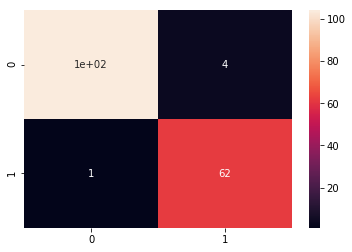

In [24]:
nn = NeuralNetwork(X_train, y_train, X_test, y_test)

### What Is A Neural Network? <a  id="whatisanetwork"></a>

Like the name suggests, neural networks are designed after the architecture of our brains. Eletrical signals are sent through layers of neurons in our brains that are all connected together and eventually forms an output that our brain can understand and act on. Just like our brains architecture, our network has several layers made up of perceptron nodes(neurons).

Each of these nodes simply holds a number. These nodes then have their numbers multiplied by the weights connecting them to the next layer. The data is inputed into the first layer of the network, there is a node for every feature in the data set. These inputs are passed through each layer of the network with the layers weights applied to them. After the inputs make it through the entire network we are left with our output. In this case we have a single output node that will be either 1 or 0(Malignent or Benign). This process is known as the forward pass. The next step is the backward pass. This is where the learning actually occurs. We find out how well our network predicted the outcome. We then move backward through the layers and updated the weights of the layers in order to improve our predictions. Nodes that are considered more important will end up having a higher weight value.

### Building Blocks <a  id="buildingblocks"></a>

Above is a very brief description of what is going in the neural network. Now we are going to look how to build it. The way I lik to think of implementing a neural network is to split it upon into several logical sections or building blocks. These are as follows:

</br>
<dl>
<dd>1. Network Initialisation</dd>

<dd>2. Forward Pass</dd>

<dd>3. Backward Pass</dd>

<dd>4. Update Weights</dd>

<dd>5. Testing & Evaluation</dd>
</dl>



## 1 - Initialisation <a  id="init"></a>

The first thing we need to do is initialise our network. Here we will determine the structure of the network including the number of nodes for each layer(input, hidden and output), the learning rate, the number of epochs and the initial random weights for each of our layers. 

<dt>Input nodes</dt> 
this is the number of features for each entry in our data set, in this case it will be 30

<dt>Hidden Nodes</dt> 
This is the number of nodes in our hidden layer. For this project I use 12 hidden nodes. This is an arbitrary number that I decided upon through experimenting with different values. 

<dt>Output Nodes</dt> 
This is simply how many outputs our network will have. In this case we are carrying out binary classification so our network can either be 0 or 1. Due to this we will only use 1 node. If we were building a classifier with more than 2 types (such as classifying different types of animals) we would have several output nodes.

<dt>Learning Rate</dt> 
The learning rate determines how much we adjust our weights during the back pass. A high number will let our network make progress quickly, but as the learning progresses we might adjust our weights too much, and increase the error as opposed to decreasing it. A low learning rate will gradually learn and be able to generalise better, but will take longer to converge and requires more training epochs. A learning rate that isnt too high or too low is recomended to begin with and then you can adjust the learning rates based on the needs of the network. For this example I decided on a learning rate of 0.1 which is generally a good starting point.

<dt>Epochs</dt>
The number of epochs determines how many times we will train our network on the data set.

<img src="imgs/init.png">

## 2 - Forward Pass <a  id="forward"></a>
<figure>
    <img src="imgs/forwardpass.png" style="widght:300px;">
    <figcaption style="text-align:center;">Example of a simple forward pass through a single layer</figcaption>
</figure>

<img src="imgs/forward.png">

As mentioned previously the forward pass is the prediction section of our network. We feed our input in through the layers of the network, applying the different weights as we go. This eventually leaves us with a prediciton. The steps in the forward pass are as follows:

<dt>1) Get the input</dt> 
The input for the layer is the output of the previous layer, or in the input layer it is simply the training data.

<dt>2) Apply the layer weights</dt> 
Now we apply the weights by getting the dot product of the inputs and the layers weights

<dt>3) Activation function</dt> 
Once we apply the weights to the inputs we apply our activation function. In this project we are using the sigmoid function. This takes in a number and turns it into a value between 0 and 1. This function suits our needs are we are looking for a binary output
<img src="imgs/sigmoid.png">

<img src="imgs/sigmoiddiagram.png">

### 3 - Backward Pass <a  id="backward"></a>

<img src="imgs/back.png">

The backwards pass is the section where our network actually learns, this is known as backpropagation through gradient descent. Here we take our prediction and compare it with the actual true value. We then move backwards through our networks and update the weights of our layers in order to improve our predictions. There are several steps in the backwards pass of the network.

<dt>1) Find the error of the network</dt> 
First we calculate how far off our prediction was. This is done by subtracting our preicted value from the true value

<dt>2) Calculate the error for each of our layers</dt> 
Now that we know the error of the network we need to find the error for each of our layers. We do this by multiplying the error of the previous layer by the derivative of the current layer.

The final layer (layer 2 in this case) will be using the network error as there is no previous layer. The derivative of the current layer is calculated using the sigmoid prime function shown below. The next layer uses the dot product of the previous error and the weights for the previous layer as the error. Once again this is multiplied by the sigmoid prime of the current layer

<img src="imgs/sigmoid_prime.png">
<img src="imgs/sigmoid_prime_diagram.png" style="height:300px;">

### 4 - Update Weights <a  id="update"></a>

Once we have completed our backward pass of the network we need to update our weights accordingly. For each layer of weights we need to carry out the following steps. 

<dt>1) Calculate how much to add to the layer weights</dt> 
for each layer of weights we need to calculate the adjustments to add to the weights. This is done by getting the dot product of the previous layer and the error of the current layer that we found in the back pass phase. We then multiply that dot product with our learning rate

<dt>2) Add the adjustments to the current layer weights</dt> 
This is as simple as it sounds. Just add the adjustments we just calculated to the weights. 

For some of the calculations we need to use the transpose of the value (.T) this is just so the 2 matrices can be multiplied correctly. This can vary for each project.

<img src="imgs/weights.png">

Congratulations you have just built the core model for your neural network! The only thing left to do is test the accuracy of our network

### 5 - Testing and Evaluation <a  id="testing"></a>

All we are doing here is recreating the forward pass in order to test how well our model works, except here we use our testing data instead of our training data. We also keep track of how many correct predictions we make and the list of predictions made.

For each each prediction made we will compare it to the actual target and see if our model is correct, updating our statistic variables.

We then print out the accuracy of our model to the terminal

<img src="imgs/test.png">

# Conclusion <a  id="conclusion"></a>

I hope this writeup is able to help others learn and understand neural networks. There is still a lot about the topic that wasn't covered here. This project simply looked at a very basic implemtation of a deep neural network. After writing this notebook I feel that I have gained a much better understanding of how neural networks actually work. This will be a big help when I move on to more complicated models using libraries such as tensorflow. 

Try playing around with this code and see what results you get. Better yet, try and recreate this project using a different data set. Try and figure out how to prepare the data, maybe add more hidden layers to improve the performance of the model. 



Below I have listed several great resources and references to the code and tutorials that I learned from.

# References <a  id="references"></a>

Preprocessing Data
https://www.kaggle.com/thebrownviking20/intro-to-keras-with-breast-cancer-data-ann

Basic Neural Network With Numpy
https://www.kaggle.com/ancientaxe/simple-neural-network-from-scratch-in-python

# Other Resources <a  id="resources"></a>

A Neural Network in 11 lines of Python
https://iamtrask.github.io/2015/07/12/basic-python-network/

Siraj Raval Channel
https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A

But what *is* a Neural Network? | Chapter 1, deep learning
https://www.youtube.com/watch?v=aircAruvnKk